In [9]:
import pandas as pd
import numpy
import math

#IMPORT GENERATORS DATA FROM NREL, INCLUDES PLANT LEVEL HEAT REATES(HR). https://data.nrel.gov/submissions/100

#plant level data with 4th-level polynomial heat rate curve
hr_curves_201617 = pd.read_csv("/Users/Michael/Downloads/CEMS_2016-2017_Heat_Rates.csv")

#plants in Texas
TX_hr_curves_201617 = hr_curves_201617.loc[hr_curves_201617["state"] == "TX"]
#fossil plant ids for Texas from NREL data
NREL_TX_fossil_ids = TX_hr_curves_201617['unit_id']
NREL_TX_fossil_ids = [float(x.split('_', 1)[0]) for x in NREL_TX_fossil_ids]


#plants in ERCOT
ERCOT_hr_curves_201617 = hr_curves_201617.loc[hr_curves_201617["NERC_region"] == "ERCOT"]
NREL_ERCOT_fossil_ids = ERCOT_hr_curves_201617['unit_id']

#WHY IS THERE SUCH A BIG DIFFERENCE BETWEEN THE NUMBER IN EACH?

#plant level data with piece-wise linear heat rate function. DOES NOT INDICATE STATE OR NERC REGION. 
#Next step: cross reference IDs to select just TX/ERCOT plants
hr_pwlinear_201516 = pd.read_csv("/Users/Michael/Downloads/CEMS_2015-2016_Piecewise_Fits.csv")

In [14]:
#Plant ids from Generators_Data.csv

#Full Generators_data.csv from OneZone_TX
GenX_TX_gens = pd.read_csv("/Users/Michael/GenX-Projects/Example_Systems/OneZone_TX/Generators_data.csv")

#Plant ids from Generates_data (includes fossil fuels and renewables)
GenX_TX_gens_IDs = pd.DataFrame(GenX_TX_gens["plant_id_eia"])

GenX_TX_fossil_gens = GenX_TX_gens.loc[(GenX_TX_gens["technology"] == "Conventional Steam Coal") | (GenX_TX_gens["technology"] == "Natural Gas Fired Combined Cycle") | (GenX_TX_gens["technology"] == "Natural Gas Fired Combustion Turbine") | (GenX_TX_gens["technology"] == "Natural Gas Steam Turbine")]

#Create list of fossil generator ids
GenX_TX_fossil_ids = []
for x in GenX_TX_fossil_gens['plant_id_eia']:
    GenX_TX_fossil_ids = GenX_TX_fossil_ids + x[1:-1].split(",")

GenX_TX_fossil_ids = [float(x) for x in GenX_TX_fossil_ids]

In [27]:
#ERCOT hourly load data, https://www.ercot.com/gridinfo/load/load_hist

#Files from ERCOT, include sub-zone load and total load
Load_ERCOT_2016 = pd.read_excel("/Users/Michael/Downloads/ERCOT_Load_2016.xlsx")['ERCOT']
Load_ERCOT_2017 = pd.read_excel("/Users/Michael/Downloads/ERCOT_Load_2017.xlsx")['ERCOT']
Load_ERCOT_2018 = pd.read_excel("/Users/Michael/Downloads/ERCOT_Load_2018.xlsx")['ERCOT']
Load_ERCOT_2019 = pd.read_excel("/Users/Michael/Downloads/ERCOT_Load_2019.xlsx")['ERCOT']

#Create the modified Load_data.modified.csv
load_data = pd.read_csv("/Users/Michael/GenX-Projects/Example_Systems/OneZone_TX/Load_data.csv")
load_data["Load_MW_z1"] = [int(x) for x in Load_ERCOT_2019]
load_data_2019 = load_data


In [16]:
#ERCOT hourly renewables generation
from pandas import DataFrame

#Annual excel files with renewable generaiton data, 15-minute intervals
#FORMAT CHANGES AFTER 2016!!!!
ERCOT_gen_excel_2016 = pd.ExcelFile("/Users/Michael/Downloads/FuelMixReport_PreviousYears/IntGenByFuel2016.xlsx")
ERCOT_gen_excel_2017 = pd.ExcelFile("/Users/Michael/Downloads/FuelMixReport_PreviousYears/IntGenByFuel2017.xlsx")
ERCOT_gen_excel_2018 = pd.ExcelFile("/Users/Michael/Downloads/FuelMixReport_PreviousYears/IntGenByFuel2018.xlsx")
ERCOT_gen_excel_2019 = pd.ExcelFile("/Users/Michael/Downloads/FuelMixReport_PreviousYears/IntGenByFuel2019.xlsx")


In [17]:
#FORMAT THE GENERATION DATA

#PRE-2016 FORMATTING

def format_gen_data_until_2016 (gen_data: pd.ExcelFile):
    #create list of sheet names containing renewable generation data
    gen_data.sheet_names
    sheets = list(gen_data.sheet_names[2:])
    sheets.reverse()

    #make a dataframe with all the sheets combined
    months_ren_gen = []

    for sheet in sheets:
        month = pd.DataFrame(gen_data.parse(sheet))
        months_ren_gen.append(month)

    ERCOT_ren_gen = pd.concat(months_ren_gen, ignore_index = True)

    #change column names to string
    col_names = ERCOT_ren_gen.columns
    ERCOT_ren_gen.columns = [str(x) for x in col_names]

    #replace nan values in 00:00:00 with 1900-01-01 00:00:00 values
    for i in range(len(ERCOT_ren_gen["Date-Fuel"])):
        if math.isnan(ERCOT_ren_gen['00:00:00'][i]) == True:
            ERCOT_ren_gen['00:00:00'][i] = ERCOT_ren_gen['1900-01-01 00:00:00'][i]
    
    return ERCOT_ren_gen

#2017-PRESENT FORMATTING

def format_gen_data_post_2016 (gen_data: pd.ExcelFile):
    #create list of sheet names containing renewable generation data
    gen_data.sheet_names
    sheets = list(gen_data.sheet_names[4:])

    months_ren_gen = []

    for sheet in sheets:
        month = pd.DataFrame(gen_data.parse(sheet))
        months_ren_gen.append(month)

    ERCOT_ren_gen = pd.concat(months_ren_gen, ignore_index = True)

    #change column names to string
    col_names = ERCOT_ren_gen.columns
    ERCOT_ren_gen.columns = [str(x) for x in col_names]

    return(ERCOT_ren_gen)


In [18]:
#function that returns hourly generation for wind and solar for data from 2016 and before
def combine_gen_data_pre_2016(gen_data: DataFrame):

    wind_gen = []
    solar_gen = []

    #for i in range(24):
    for i in range(len(gen_data["Date-Fuel"])):
        if gen_data["Date-Fuel"][i].split("_")[-1] == "Solar":
            for hour in range(23):
                hourly_solar = 0
                for period in range(4):
                    hourly_solar = hourly_solar + gen_data.iloc[i][2 + 4*hour + period]
                solar_gen.append(hourly_solar)
        
        if gen_data["Date-Fuel"][i].split("_")[-1] == "Wind":
            for hour in range(int(23)):
                hourly_wind = 0
                for period in range(4):
                    hourly_wind = hourly_wind + gen_data.iloc[i][2 + 4*hour + period]
                wind_gen.append(hourly_wind)

    return solar_gen, wind_gen

#function that returns hourly generation for wind and solar for data from after 2016
def combine_gen_data_post_2016(gen_data: DataFrame):

    wind_gen = []
    solar_gen = []

    #for i in range(24):
    for i in range(len(gen_data["Fuel"])):
        if gen_data["Fuel"][i] == "Solar":
            for hour in range(int(24)):
                hourly_solar = 0
                for period in range(4):
                    hourly_solar = hourly_solar + gen_data.iloc[i][4 + 4*hour + period]
                if hourly_solar > 0.000001:
                    solar_gen.append(hourly_solar)
                else:
                    solar_gen.append(0)
        
        if gen_data["Fuel"][i] == "Wind":
            for hour in range(int(24)):
                hourly_wind = 0
                for period in range(4):
                    hourly_wind = hourly_wind + gen_data.iloc[i][4 + 4*hour + period]
                wind_gen.append(hourly_wind)

    return solar_gen, wind_gen

In [31]:
#Create the modified Generators_variability_modified file based on the Generators_Variability givne in Texas One Zone

gen_var_mod = pd.read_csv("/Users/Michael/GenX-Projects/Example_Systems/OneZone_TX/Generators_variability_modified.csv")
#gen_var_mod.reset_index(drop=True, inplace=True)
gen_var_mod.drop(gen_var_mod.columns[[0]], axis = 1, inplace = True)

#from https://www.ercot.com/gridinfo/resource/2020, released Jan 2020
wind_cap_2019 = 23860
solar_cap_2019 = 2281



#use functinos above to generate renewable production timeeseries
ERCOT_ren_gen = format_gen_data_post_2016(ERCOT_gen_excel_2019)
solar_gen, wind_gen = combine_gen_data_post_2016(ERCOT_ren_gen)

#weight of renewable production (hourly production/total capacity)
weighted_solar_gen_2019 = [x / solar_cap_2019 for x in solar_gen]
weighted_wind_gen_2019 = [x / wind_cap_2019 for x in wind_gen]

#replace the wind and solar capacity factors with 2019 data
gen_var_mod["onshore_wind_turbine"] = weighted_wind_gen_2019
gen_var_mod["solar_photovoltaic"] = weighted_solar_gen_2019


In [32]:
gen_var = pd.read_csv("/Users/Michael/GenX-main/Example_Systems/OneZone_TX_Prices/Generators_variability_more_clusters.csv")

gen_var["onshore_wind_turbine"] = weighted_wind_gen_2019
gen_var["solar_photovoltaic"] = weighted_solar_gen_2019


#THERE WAS A NaN VALUE IN THE WIND GENERATION FROM ERCOT
#USED A QUICK PATCH TO CONTINUE TESTING -- THIS IS NOT A FINAL SOLUTION!
#SIMPLY REPLACED THE NaN VALUE WITH THE VALUE OF THE HOUR BEFORE

missing = pd.isnull(gen_var["onshore_wind_turbine"])
gen_var[missing]

gen_var.iloc[1634]["onshore_wind_turbine"] 

gen_var.iloc[1634, gen_var.columns.get_loc('onshore_wind_turbine')] = gen_var.iloc[1633]["onshore_wind_turbine"] 
gen_var.iloc[1634, gen_var.columns.get_loc('onshore_wind_turbine')]

gen_var.to_csv("/Users/Michael/GenX-main/Example_Systems/OneZone_TX_Prices/Generators_variability.csv")
load_data_2019.to_csv("/Users/Michael/GenX-main/Example_Systems/OneZone_TX_Prices/Load_data.csv", index = False)

In [ ]:

#THERE WAS A NaN VALUE IN THE WIND GENERATION FROM ERCOT
#USED A QUICK PATCH TO CONTINUE TESTING -- THIS IS NOT A FINAL SOLUTION!
#SIMPLY REPLACED THE NaN VALUE WITH THE VALUE OF THE HOUR BEFORE

missing = pd.isnull(gen_var_mod["onshore_wind_turbine"])
gen_var_mod[missing]

gen_var_mod.iloc[1634]["onshore_wind_turbine"] 

gen_var_mod.iloc[1634, gen_var_mod.columns.get_loc('onshore_wind_turbine')] = gen_var_mod.iloc[1633]["onshore_wind_turbine"] 
gen_var_mod.iloc[1634, gen_var_mod.columns.get_loc('onshore_wind_turbine')]


0.33050327020117354

In [20]:
#Save the modified data input files to OneZone_TX_prices
gen_var_mod.to_csv("/Users/Michael/GenX-main/Example_Systems/OneZone_TX_Prices/Generators_variability.csv")
load_data_2019.to_csv("/Users/Michael/GenX-main/Example_Systems/OneZone_TX_Prices/Load_data.csv", index = False)


#SNL energy to get gas and coal prices, ask for a license
#compare the dispatch to the actualy ERCOt dispatch, sanity check by fuel type
#down the road, let's check out the impact of nuclear off-lining
#Hydro-quebec has some kind of variability booster


In [ ]:
#modify the generators_data.csv

gen_data_mod = pd.read_csv("/Users/Michael/GenX-main/Example_Systems/OneZone_TX_Prices/Generators_data.csv")
#gen_data_mod.drop(gen_data_mod.columns[[0]], axis = 1, inplace = True)

wind_cap_2019 = 23860
solar_cap_2019 = 2281

#chanfge wolar and wind capacities
gen_data_mod.at[18, "Existing_Cap_MW"] = solar_cap_2019
gen_data_mod.at[16, "Existing_Cap_MW"] = wind_cap_2019
gen_data_mod.at[18, "Min_Cap_MW"] = solar_cap_2019
gen_data_mod.at[16, "Min_Cap_MW"] = wind_cap_2019

gen_data_mod.to_csv("/Users/Michael/GenX-main/Example_Systems/OneZone_TX_Prices/Generators_Data.csv", index = False)






In [10]:
Disp_2019 = pd.ExcelFile("/Users/Michael/Downloads/FuelMixReport_PreviousYears/IntGenbyFuel2019.xlsx")

sheets = list(Disp_2019.sheet_names[4:])

    #make a dataframe with all the sheets combined
months_disp_2019 = []

for sheet in sheets:
    month = pd.DataFrame(Disp_2019.parse(sheet))
    months_disp_2019.append(month)

disp_2019 = pd.concat(months_disp_2019, ignore_index = True)



In [11]:
hourly_gas_disp_emp_2019 = []

for day in disp_2019[disp_2019["Fuel"] == 'Gas'].index:
    for hour in range(24):
        hourly_avg = 0
        for x in range(4):
            hourly_avg = hourly_avg + disp_2019.iloc[day][4 + hour*4 + x]
        hourly_gas_disp_emp_2019.append(hourly_avg)

hourly_gas_cc_disp_emp_2019 = []

for day in disp_2019[disp_2019["Fuel"] == 'Gas-CC'].index:
    for hour in range(24):
        hourly_avg = 0
        for x in range(4):
            hourly_avg = hourly_avg + disp_2019.iloc[day][4 + hour*4 + x]
        hourly_gas_cc_disp_emp_2019.append(hourly_avg)


In [12]:
import numpy as np

gen_types = list(set(disp_2019["Fuel"]))
hourly_disp = pd.DataFrame(pd.np.empty((8760, len(gen_types))) * pd.np.nan, columns = gen_types)

ng = [0]
ng_cc = [0]
wind = [0]
solar = [0]
coal = [0]
hydro = [0]
nuclear = [0]
biomass = [0]
other = [0]

for i in range(len(disp_2019)):
   if disp_2019["Fuel"][i] == "Gas":
      for hour in range(24):
         hourly_avg = 0
         for x in range(4):
            hourly_avg = hourly_avg + disp_2019.iloc[i][4 + hour*4 + x]
         ng.append(hourly_avg)

   if disp_2019["Fuel"][i] == "Gas-CC":
      for hour in range(24):
         hourly_avg = 0
         for x in range(4):
            hourly_avg = hourly_avg + disp_2019.iloc[i][4 + hour*4 + x]
         ng_cc.append(hourly_avg)

   if disp_2019["Fuel"][i] == "Wind":
      for hour in range(24):
         hourly_avg = 0
         for x in range(4):
            hourly_avg = hourly_avg + disp_2019.iloc[i][4 + hour*4 + x]
         wind.append(hourly_avg)
   
   if disp_2019["Fuel"][i] == "Solar":
      for hour in range(24):
         hourly_avg = 0
         for x in range(4):
            hourly_avg = hourly_avg + disp_2019.iloc[i][4 + hour*4 + x]
         solar.append(hourly_avg)

   if disp_2019["Fuel"][i] == "Coal":
      for hour in range(24):
         hourly_avg = 0
         for x in range(4):
            hourly_avg = hourly_avg + disp_2019.iloc[i][4 + hour*4 + x]
         coal.append(hourly_avg)

   if disp_2019["Fuel"][i] == "Hydro":
      for hour in range(24):
         hourly_avg = 0
         for x in range(4):
            hourly_avg = hourly_avg + disp_2019.iloc[i][4 + hour*4 + x]
         hydro.append(hourly_avg)

   if disp_2019["Fuel"][i] == "Nuclear":
      for hour in range(24):
         hourly_avg = 0
         for x in range(4):
            hourly_avg = hourly_avg + disp_2019.iloc[i][4 + hour*4 + x]
         nuclear.append(hourly_avg)

   if disp_2019["Fuel"][i] == "Biomass":
      for hour in range(24):
         hourly_avg = 0
         for x in range(4):
            hourly_avg = hourly_avg + disp_2019.iloc[i][4 + hour*4 + x]
         biomass.append(hourly_avg)

   if disp_2019["Fuel"][i] == "Other":
      for hour in range(24):
         hourly_avg = 0
         for x in range(4):
            hourly_avg = hourly_avg + disp_2019.iloc[i][4 + hour*4 + x]
         other.append(hourly_avg)




/var/folders/81/p8jw9pfs533d7sbpx6b_3_qc0000gn/T/ipykernel_71115/1182417577.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  hourly_disp = pd.DataFrame(pd.np.empty((8760, len(gen_types))) * pd.np.nan, columns = gen_types)
/var/folders/81/p8jw9pfs533d7sbpx6b_3_qc0000gn/T/ipykernel_71115/1182417577.py:4: RuntimeWarning: invalid value encountered in multiply
  hourly_disp = pd.DataFrame(pd.np.empty((8760, len(gen_types))) * pd.np.nan, columns = gen_types)


In [45]:
ng_emp_disp_2019 = [ng[x] + ng_cc[x] for x in range(len(ng))][1:]

print("gas: ", numpy.nansum(ng) + numpy.nansum(ng_cc))
print("wind: ", numpy.nansum(wind))
print("solar: ", numpy.nansum(solar))
print("coal: ", numpy.nansum(coal))
print("nuclear: ", numpy.nansum(nuclear))
print("biomass: ", numpy.nansum(biomass))
print("hydro: ", numpy.nansum(hydro))
print("other: ", numpy.nansum(other))

print("total: ",numpy.nansum(ng_emp_disp_2019) + numpy.nansum(wind) + numpy.nansum(solar)+ numpy.nansum(coal)+ numpy.nansum(hydro) + numpy.nansum(biomass) + numpy.nansum(other)+ numpy.nansum(nuclear) )


gas:  181760055.564055
wind:  76694931.50429901
solar:  4397856.629446001
coal:  77850615.17037101
nuclear:  41309820.316985995
biomass:  420635.295095
hydro:  955864.057609
other:  23740.57384
total:  383413519.111701


Text(0, 0.5, 'Dispatch (MWh)')

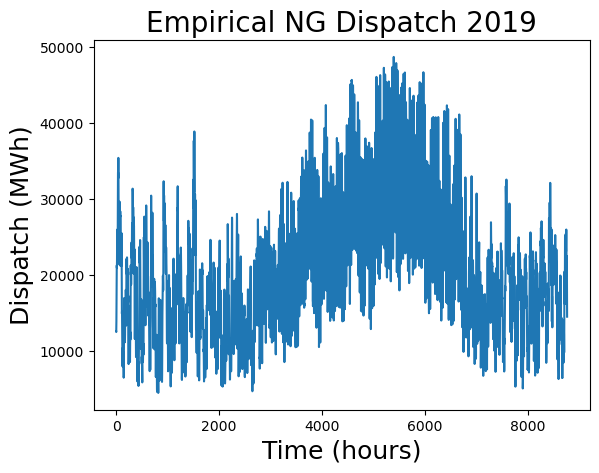

In [16]:
plt.plot(ng_emp_disp_2019)

plt.title("Empirical NG Dispatch 2019", size = 20)
plt.xlabel("Time (hours)", fontsize = 18)
plt.ylabel("Dispatch (MWh)", fontsize = 18)

In [18]:
hourly_disp.columns
len(disp_2019)
numpy.nansum(hourly_disp["Gas"]) + numpy.nansum(hourly_disp["Gas-CC"])

0.0

181760055.56405503

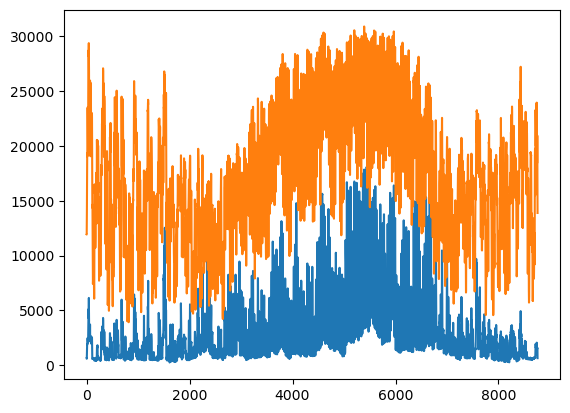

In [19]:
import matplotlib.pyplot as plt


plt.plot(hourly_gas_disp_emp_2019)
plt.plot(hourly_gas_cc_disp_emp_2019)

numpy.nansum(hourly_gas_disp_emp_2019) + numpy.nansum(hourly_gas_cc_disp_emp_2019)


In [39]:
sim_disp_2019 = pd.read_csv("/Users/Michael/GenX-main/Example_Systems/OneZone_TX_Prices/Results_19/power.csv")

ng_col = [col for col in sim_disp_2019 if col.startswith('natural')]
coal_col = [col for col in sim_disp_2019 if col.startswith('conventional')]
nuclear_col = [col for col in sim_disp_2019 if col.startswith('nuclear')]


ng_sim_disp = sim_disp_2019[ng_col]
coal_sim_disp = sim_disp_2019[coal_col]
nuclear_sim_disp = sim_disp_2019[nuclear_col]


sim_disp_2019['ng_sum'] = sim_disp_2019[ng_col].sum(axis=1)
sim_disp_2019['coal_sum'] = sim_disp_2019[coal_col].sum(axis=1)
sim_disp_2019['nuclear_sum'] = sim_disp_2019[nuclear_col].sum(axis=1)





In [43]:

sum(sim_disp_2019.onshore_wind_turbine[2:])
sum(sim_disp_2019.solar_photovoltaic[2:])
sum(sim_disp_2019.ng_sum[2:])
sum(sim_disp_2019.nuclear_sum[2:])
sum(sim_disp_2019.biomass[2:])
sum(sim_disp_2019.coal_sum[2:])
sum(sim_disp_2019.small_hydroelectric[2:])



0.0

Text(0, 0.5, 'Dispatch (MWh)')

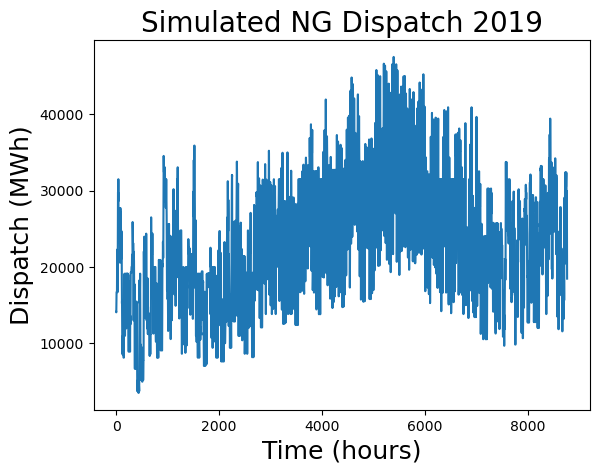

In [25]:
plt.plot(sim_disp_2019['ng_sum'][2:])

plt.title("Simulated NG Dispatch 2019", size = 20)
plt.xlabel("Time (hours)", fontsize = 18)
plt.ylabel("Dispatch (MWh)", fontsize = 18)

Text(0, 0.5, 'Empirical - Simulated NG Dispatch (MWh)')

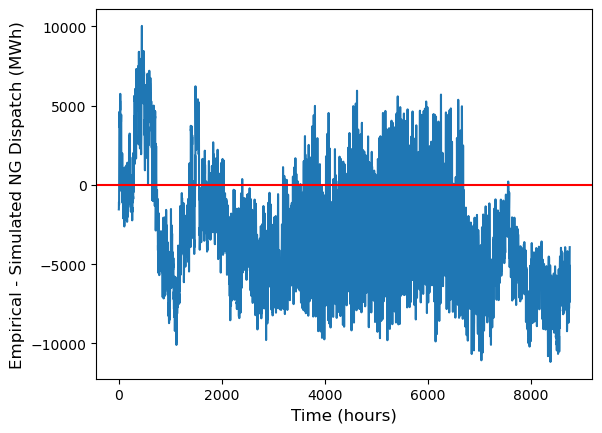

In [34]:
ng_disp_diff = [ng_emp_disp_2019[x] - sim_disp_2019['ng_sum'][2 + x] for x in range(len(ng_emp_disp_2019))]

plt.plot(ng_disp_diff)
plt.axhline(y = 0, color = 'r')
#plt.title("Simulated NG Dispatch 2019", size = 20)
plt.xlabel("Time (hours)", fontsize = 12)
plt.ylabel("Empirical - Simulated NG Dispatch (MWh)", fontsize = 12)

In [27]:
len(sim_disp_2019['ng_sum'][2:] )

8760

In [38]:
ng_df = pd.concat([pd.DataFrame(ng_emp_disp_2019), sim_disp_2019['ng_sum'][2:] ], axis = 1)
ng_df.columns =["Actual", "Simulated"]



print(ng_df.corr(method = 'pearson'))

             Actual  Simulated
Actual     1.000000   0.901162
Simulated  0.901162   1.000000
